# Synthetic dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import beta

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['legend.fontsize'] = 16

def plot_contribution(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None, cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i),fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
        else:
            if vmin is None:
                vmin = np.floor(b[i].min() * 10) / 10
            if vmax is None:
                vmax = np.ceil(b[i].max() * 10) / 10
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=vmin, vmax=vmax, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.tick_params(axis='x', colors=(0,0,0,0))
            ax.tick_params(axis='y', colors=(0,0,0,0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')

## Data generation

In [3]:
size = 50

b0 = np.ones((size, size))
b1 = np.ones((size, size))
b2 = np.ones((size, size))
b3 = np.ones((size, size))
b4 = np.ones((size, size))
# noise = np.ones((size, size))

for i in range(size):
    for j in range(size):
        # b0[i, j] = 6 * np.exp(-((i - 40)**2 + (j - 10)**2) / (2 * 12**2)) + 6 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))
        b1[i, j] = 2.25 * beta.pdf(i / 49, 2, 2) * beta.pdf(j / 49, 3, 2)
        b2[i, j] = (i + j) / 49 * 3
        b3[i, j] = 6 * np.exp(-((i - 20)**2 + (j - 30)**2) / (2 * 15**2))
        # b1[i, j] = gamma.pdf(i / 29, 2) * gamma.pdf(j / 29, 3)
        # b2[i, j] = (i + j) / 29 * 3
        # b3[i, j] = 6 * np.exp(-((i - 20)**2 + (j - 10)**2) / (2 * 12**2))

In [4]:
b0 = b0.reshape(-1)
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
b3 = b3.reshape(-1)
# b4 = b4.reshape(-1)
# noise = noise.reshape(-1)

In [5]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)
X5 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4, X5]).T
u = np.array([np.linspace(0,size - 1,num=size)] * size).reshape(-1)
v = np.array([np.linspace(0,size - 1,num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u,v)))

k = X.shape[1]
n = X.shape[0]

In [6]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1), columns=['X1', 'X2', 'X3', 'X4', 'X5', 'x_coord', 'y_coord'])

In [7]:
X_coords

X1        X2        X3        X4        X5  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011  1.623438      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414  1.663881      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029 -0.209243      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231  0.540090      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233 -0.125796      4.0      0.0
...        ...       ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451 -1.925222     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732  0.100871     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266  0.610802     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300  1.650016     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717  1.276653     49.0     49.0

[2500 rows x 7 columns]

In [8]:
# f0 = b0
f1 = b1 * X_coords.values[:, 0]
f2 = b2 * X_coords.values[:, 1]
f3 = b3 * X_coords.values[:, 2]
f4 = X_coords.values[:, 3] * 2
f5 = np.abs(X_coords.values[:, 4]) * 2

In [9]:
y = pd.DataFrame(f1 + f2 + f3 + f4 + f5, columns=['y'])

In [10]:
b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]
# b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]

In [11]:
sub_titles = [r'$f_0(u,v)$', r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']
# sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']

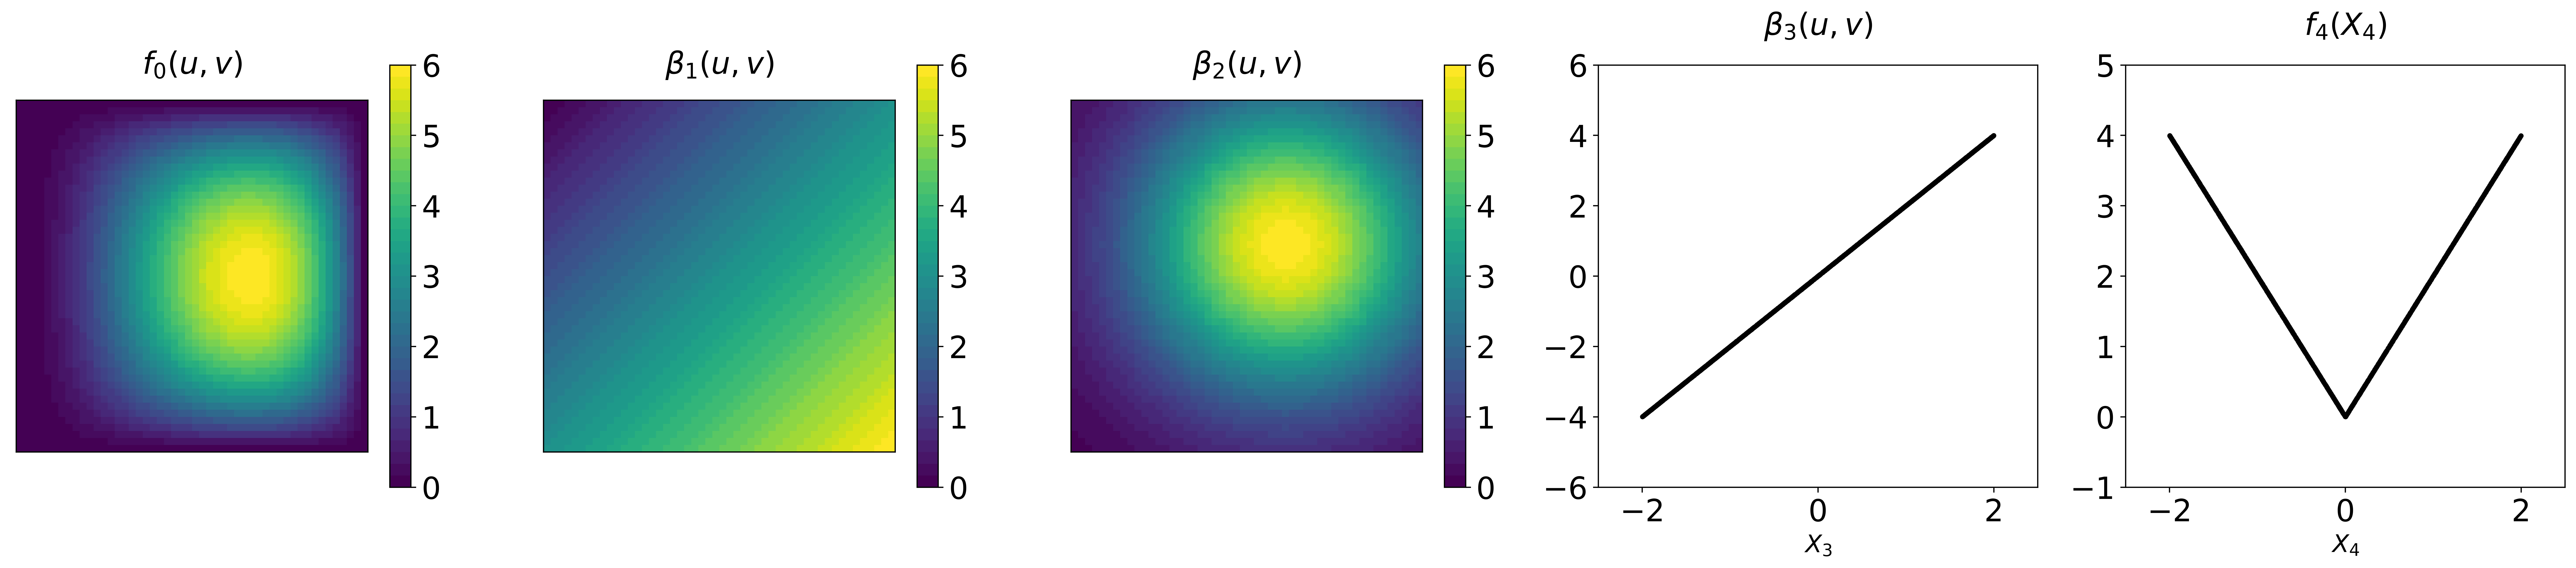

In [12]:
plot_contribution(b=b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='TrueModel', non_spatial=[3, 4], size=size)

In [13]:
b1.max()

5.995614858277373

In [14]:
class Model:
    def __init__(self, f):
        self.predict = f

In [15]:
def true_model_predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1]
    v = X_coords[:, -2]
    b1 = 2.25 * beta.pdf(u / 49, 2, 2) * beta.pdf(v / 49, 3, 2)
    b2 = (u + v) / 49 * 3
    b3 = 6 * np.exp(-((u - 20)**2 + (v - 30)**2) / (2 * 15**2))
    f1 = b1 * X_coords[:, 0]
    f2 = b2 * X_coords[:, 1]
    f3 = b3 * X_coords[:, 2]
    f4 = X_coords[:, 3] * 2
    f5 = np.abs(X_coords[:, 4]) * 2
    y_pred = f1 + f2 + f3 + f4 + f5
    return y_pred

In [16]:
true_model = Model(true_model_predict)

In [17]:
loc = X_coords[['x_coord', 'y_coord']]

In [18]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)

In [19]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)

In [20]:
explainer = GeoConformalizedExplainer(prediction_f=true_model.predict,
                                                       x_train=X_train,
                                                       x_calib=X_calib,
                                                       coord_calib=loc_calib.values,
                                                       miscoverage_level=0.1,
                                                       band_width=20)

In [ ]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

Training SHAP


 14%|█▍        | 280/2000 [00:20<02:12, 13.02it/s]

In [22]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X0                1.0000  0.888754  1.027820   9.496171       4.922192
X1                0.8516  0.747858  1.688892  11.312499      11.268369
X2                1.0000  0.956250  0.748929  12.820547       8.238152
X3                0.9988  0.930122  0.620348   5.507205       5.566377
X4                0.0000  0.252542  1.026010   1.408369       1.406267
X5                0.9832 -0.123953  1.799117   2.879855       1.341678
X6                0.9960  0.324091  1.093909   1.770413       1.270919

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

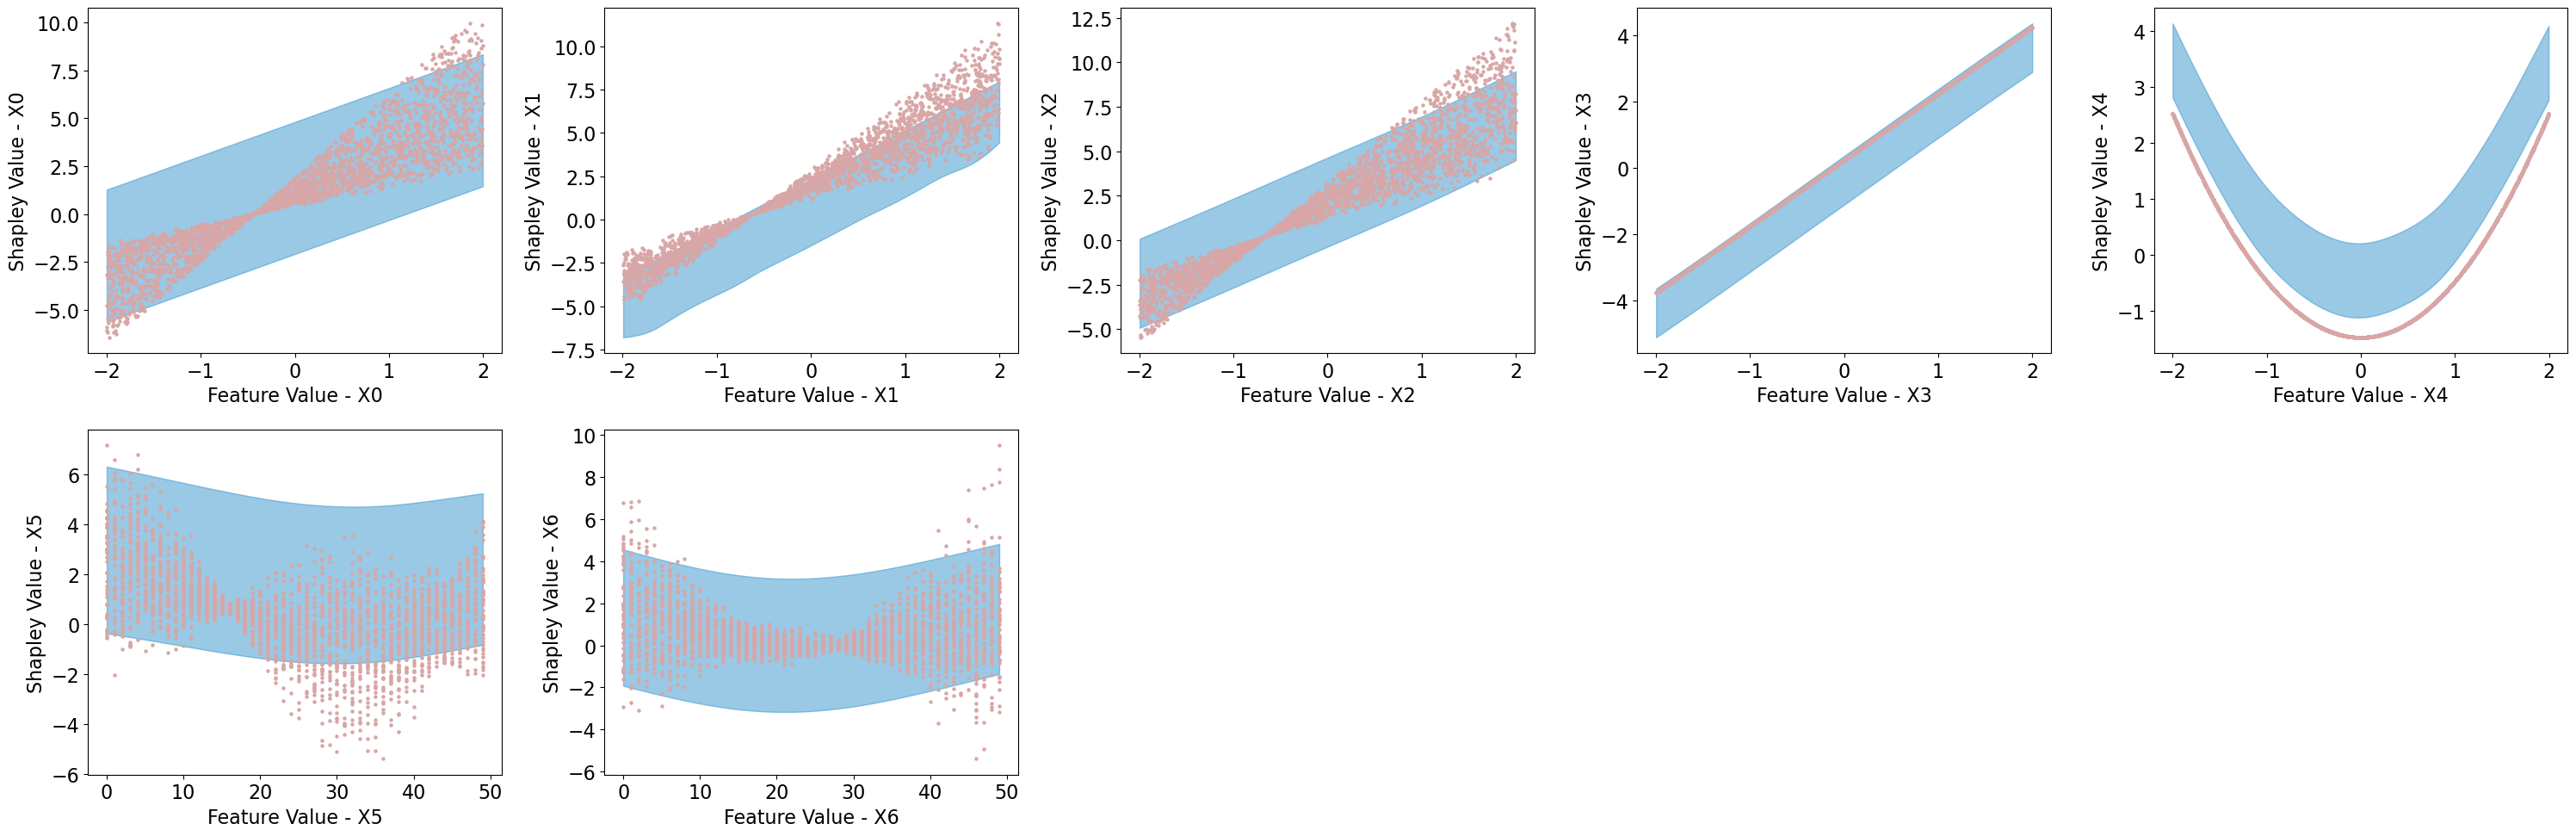

In [47]:
results.plot_partial_dependence_with_fitted_bounds()

In [23]:
pred_results = results.result_geo

In [24]:
pred_results

X0_shap   X1_shap   X2_shap   X3_shap   X4_shap   X5_shap   X6_shap  \
0     0.545982  2.411262  2.866422  2.617221  1.160645  0.774737  0.130002   
1     1.159770  0.578229 -0.230059  2.282026  1.293594  2.679174  1.820217   
2     1.751172 -0.013061 -0.589018 -3.750859 -1.431122  2.652610  1.985625   
3     1.059604  2.721737 -0.806346 -0.615263 -1.183207  2.124477  0.871745   
4    -1.380575  1.263253  0.220593  2.357664 -1.459080  3.139587  2.792095   
...        ...       ...       ...       ...       ...       ...       ...   
2495 -1.836472 -0.323019  1.517433 -2.493704  2.231576 -0.450463  3.004680   
2496  0.917068  0.148498  2.389560  0.930663 -1.464730 -0.418836 -0.260987   
2497 -1.488909 -1.431002  0.151500  3.249731 -1.101826 -0.060659  2.777833   
2498 -0.197498 -1.477769  2.771778  4.231799  1.247649 -0.372240 -0.195521   
2499  1.214700 -0.217356  2.369032  1.208633  0.154939 -0.571474 -0.665167   

      X0_value  X1_value  X2_value  ...  X6_geo_uncertainty  X6_uncertainty  \
0     0.104114  0.964917  1.011381  ...            2.905630        3.164681   
1     0.741269 -0.440030 -0.936705  ...            2.905630        3.164681   
2     1.342697 -0.875739 -1.148677  ...            2.905630        3.164681   
3     0.615061  1.082512 -1.266801  ...            2.905630        3.164681   
4    -1.851912  0.026923 -0.659943  ...            2.905630        3.164681   
...        ...       ...       ...  ...                 ...             ...   
2495 -1.798074 -0.779403  0.012337  ...            3.290781        3.164681   
2496  0.239688 -0.666447  0.497581  ...            3.290781        3.164681   
2497 -1.719665 -1.038000 -0.700350  ...            3.290781        3.164681   
2498 -0.650496 -1.045958  0.776005  ...            3.290781        3.164681   
2499  0.801800 -0.750421  0.581807  ...            3.290781        3.164681   

      X6_upper_bound  X6_lower_bound  X6_coverage_probability   X6_pred  \
0           3.129163       -2.682097                    0.996  0.223533   
1           4.287012       -1.524248                    0.996  1.381382   
2           4.559113       -1.252147                    0.996  1.653483   
3           3.414223       -2.397036                    0.996  0.508594   
4           4.905999       -0.905261                    0.996  2.000369   
...              ...             ...                      ...       ...   
2495        5.757161       -0.824401                    0.996  2.466380   
2496        4.121108       -2.460455                    0.996  0.830326   
2497        5.674408       -0.907154                    0.996  2.383627   
2498        4.000766       -2.580796                    0.996  0.709985   
2499        3.580128       -3.001435                    0.996  0.289346   

      X6_shap_abs     x     y                   geometry  
0        0.130002   0.0   0.0    POINT (0.00000 0.00000)  
1        1.820217   1.0   0.0    POINT (1.00000 0.00000)  
2        1.985625   2.0   0.0    POINT (2.00000 0.00000)  
3        0.871745   3.0   0.0    POINT (3.00000 0.00000)  
4        2.792095   4.0   0.0    POINT (4.00000 0.00000)  
...           ...   ...   ...                        ...  
2495     3.004680  45.0  49.0  POINT (45.00000 49.00000)  
2496     0.260987  46.0  49.0  POINT (46.00000 49.00000)  
2497     2.777833  47.0  49.0  POINT (47.00000 49.00000)  
2498     0.195521  48.0  49.0  POINT (48.00000 49.00000)  
2499     0.665167  49.0  49.0  POINT (49.00000 49.00000)  

[2500 rows x 66 columns]

In [25]:
sub_titles = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\phi_4$', r'$\phi_5$']

In [26]:
pred_b = [pred_results['X0_pred'].values,
          pred_results['X1_pred'].values,
          pred_results['X2_pred'].values,
          [X_coords.values[:, 3], pred_results['X3_pred'].values, -6, 6],
          [X_coords.values[:, 4], pred_results['X4_pred'].values, -2, 4]]

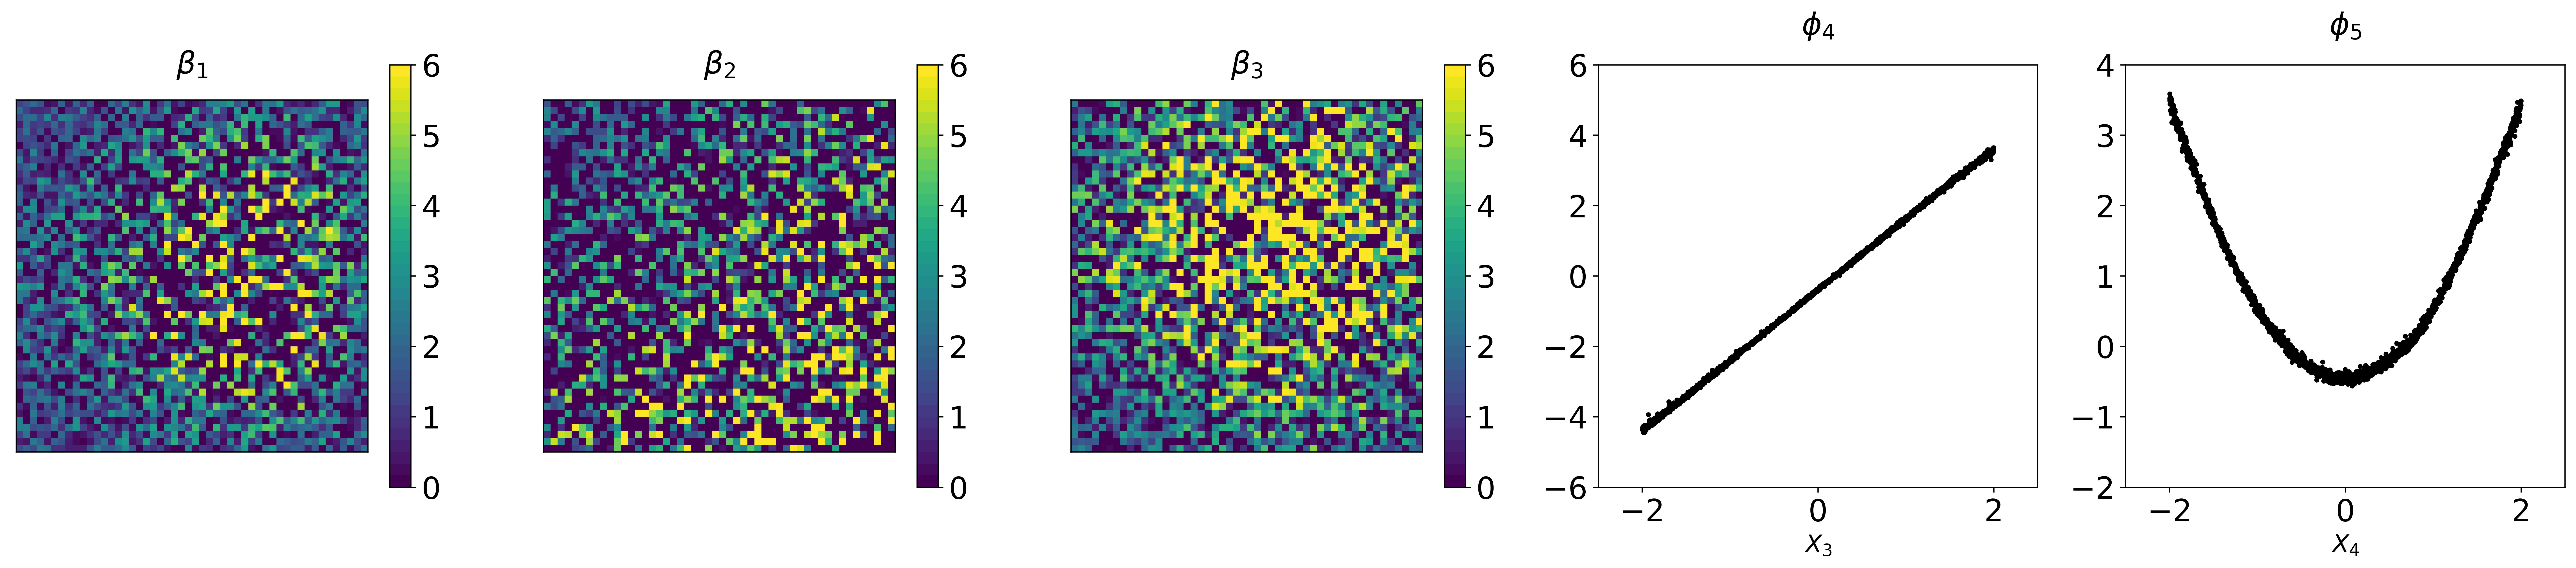

In [27]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4], size=size)

In [28]:
pred_b_shap = [pred_results['X0_shap'].values,
          pred_results['X1_shap'].values,
          pred_results['X2_shap'].values,
          [X_coords.values[:, 3], pred_results['X3_shap'].values, -6, 6],
          [X_coords.values[:, 4], pred_results['X4_shap'].values, -2, 4]]

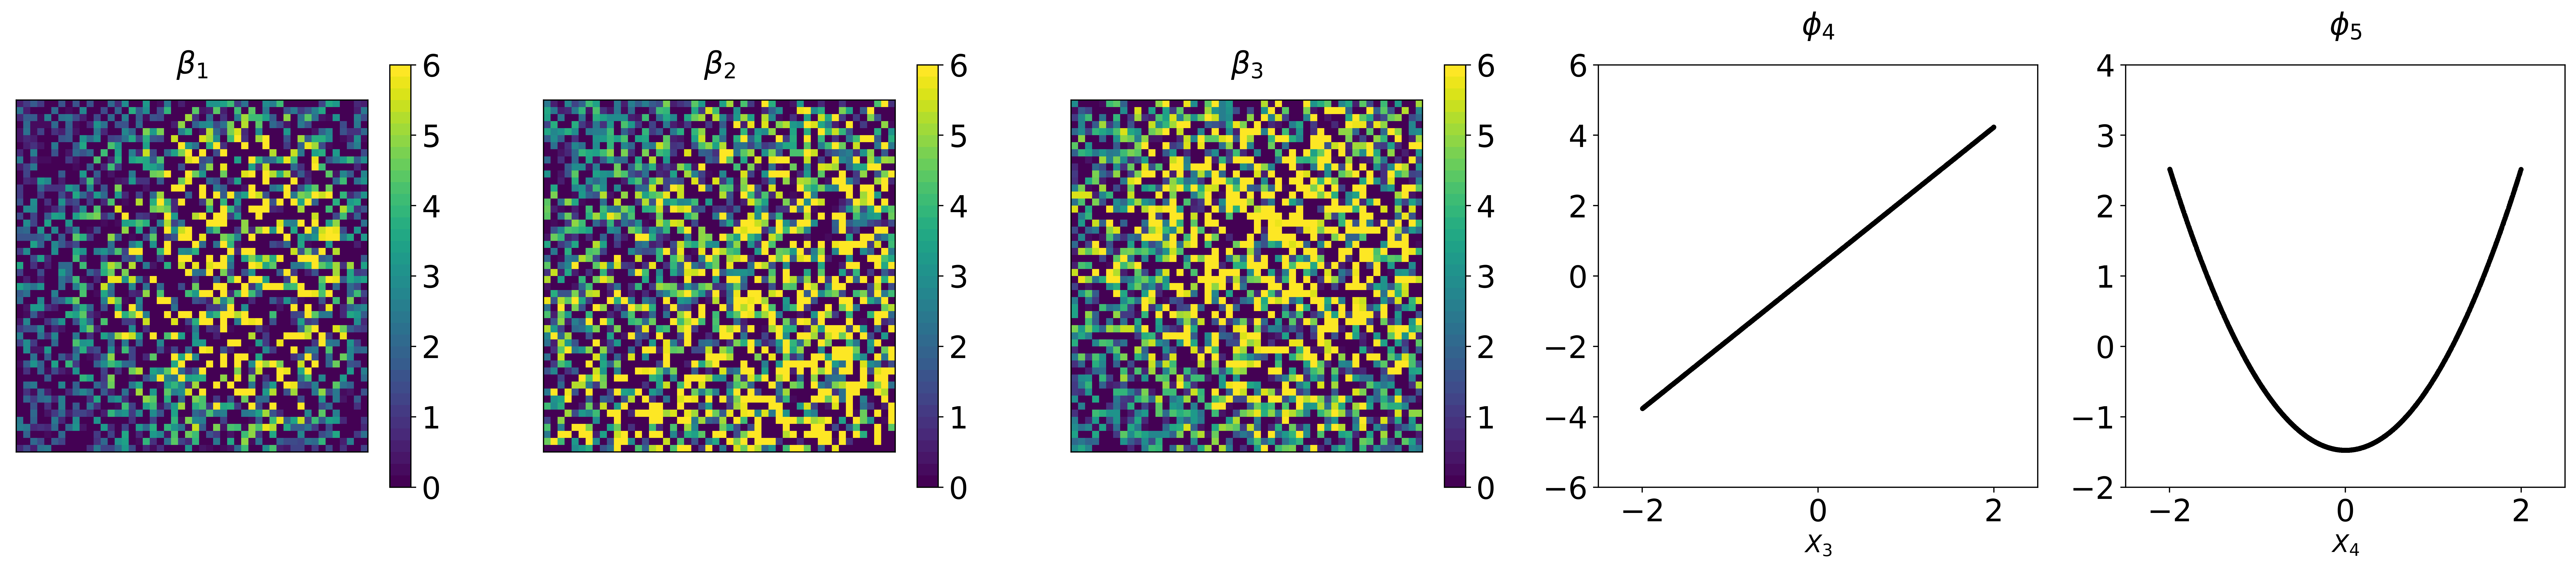

In [29]:
plot_contribution(pred_b_shap, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - KernelSHAP', non_spatial=[3, 4], size=size)

In [30]:
shap_pred_gwr = results.get_svc(cols=[0, 1, 2], coef_type='gwr', bw_max=10)

In [31]:
pred_b_ = [shap_pred_gwr[:, 0],
          shap_pred_gwr[:, 1],
          shap_pred_gwr[:, 2],
          [X_coords.values[:, 3], pred_results['X3_pred'].values, -6, 6],
          [X_coords.values[:, 4], pred_results['X4_pred'].values, -2, 4]]

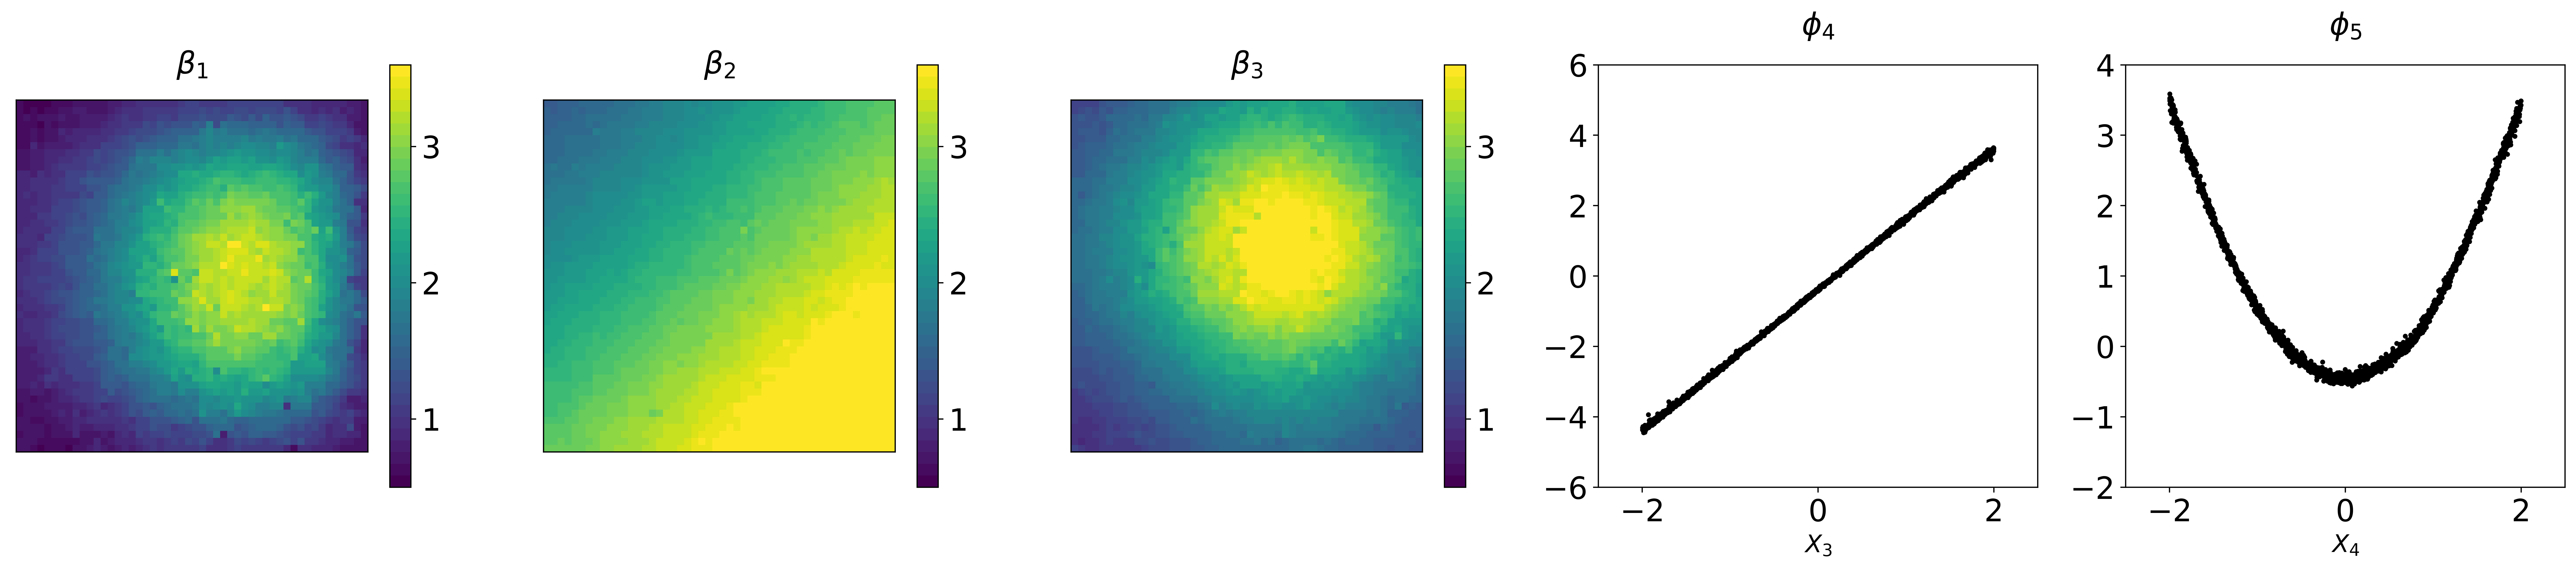

In [32]:
plot_contribution(pred_b_, k=5, sub_titles=sub_titles, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4], size=size)

In [33]:
X1_cover = (pred_results['X1_shap'] <= pred_results['X1_upper_bound']) & (pred_results['X1_shap'] >= pred_results['X1_lower_bound'])

In [34]:
X2_cover = (pred_results['X2_shap'] <= pred_results['X2_upper_bound']) & (pred_results['X2_shap'] >= pred_results['X2_lower_bound'])

In [35]:
X3_cover = (pred_results['X3_shap'] <= pred_results['X3_upper_bound']) & (pred_results['X3_shap'] >= pred_results['X3_lower_bound'])

In [36]:
b_cover = [X1_cover.values, X2_cover.values, X3_cover.values]

In [37]:
sub_titles = [r'$Cover_1$', r'$Cover_2$', r'$Cover_3$']

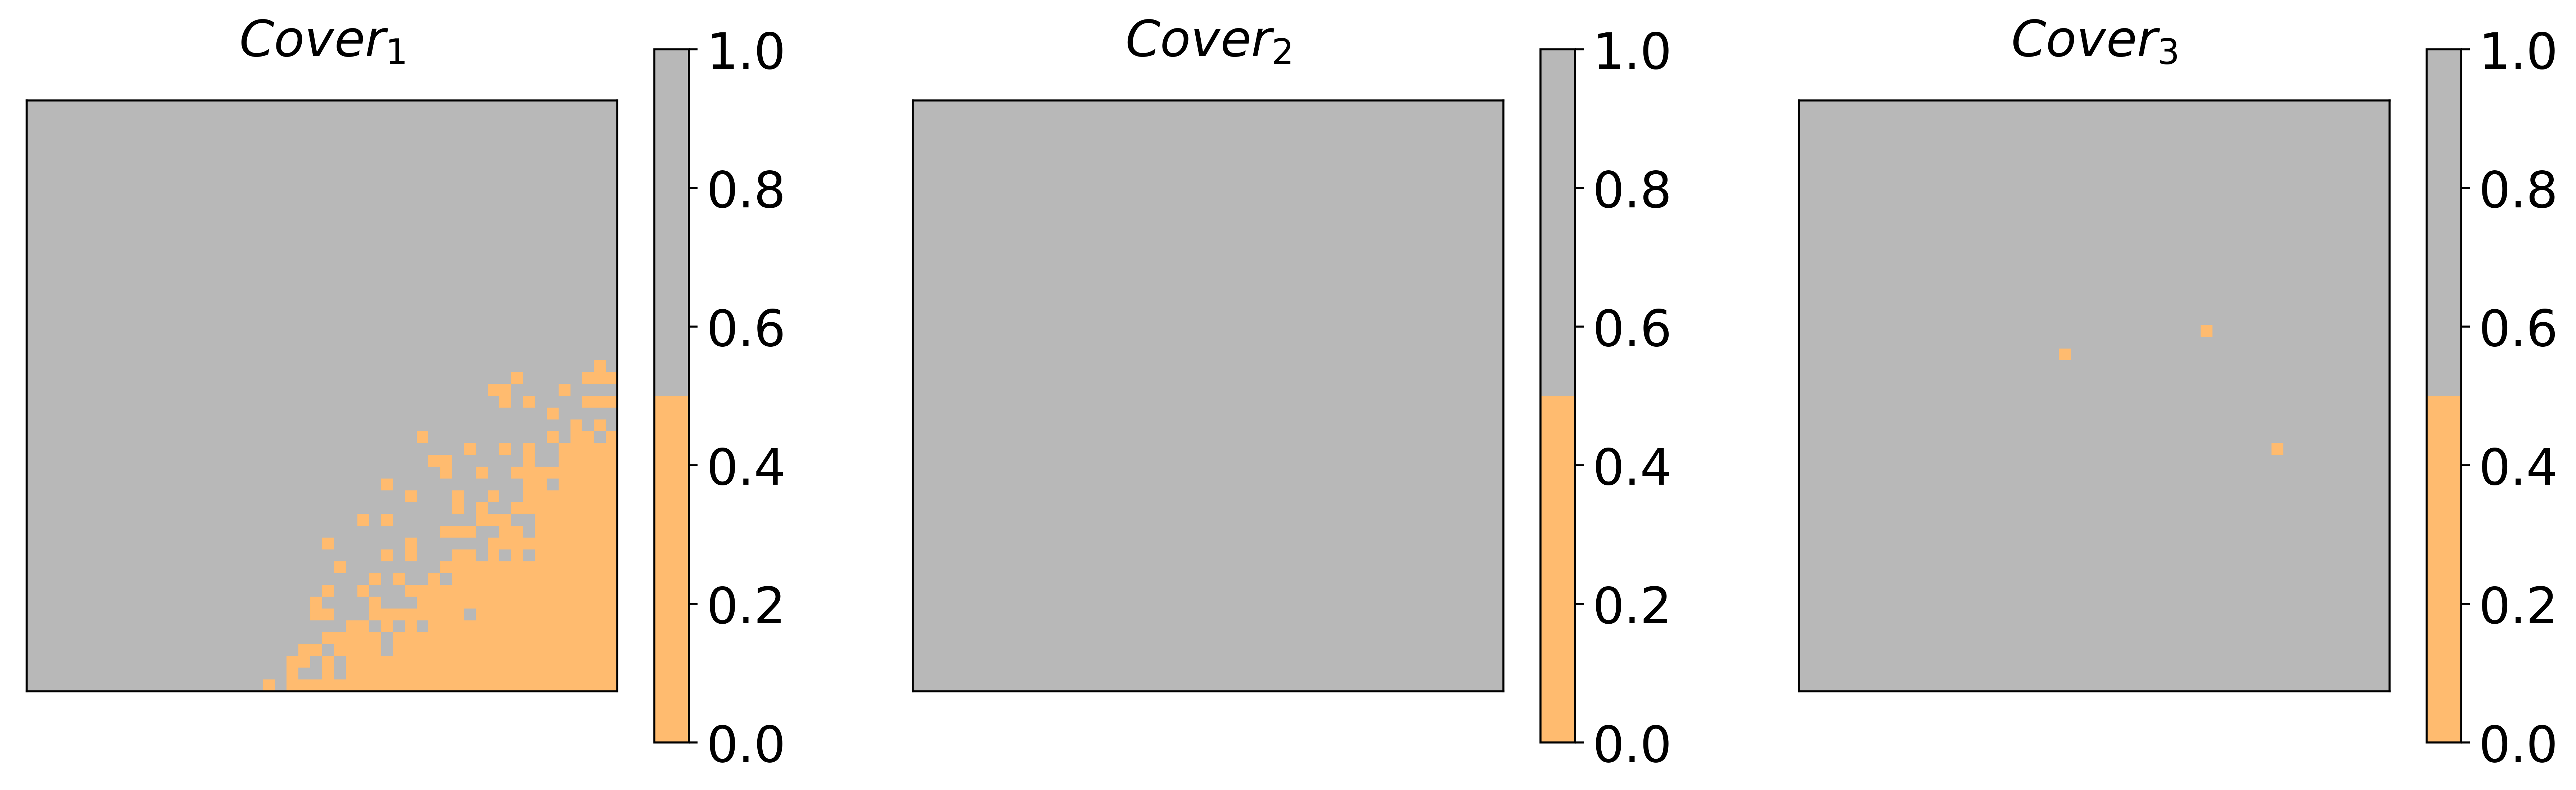

In [38]:
binary_cmap = ListedColormap(['#ffbb6f', '#b8b8b8'])
plot_contribution(b_cover, k=3, sub_titles=sub_titles, vmin=0, vmax=1, title='Coverage - ConformalSHAP', non_spatial=[], cmap=binary_cmap)

In [39]:
plt.rcParams['font.size'] = 16

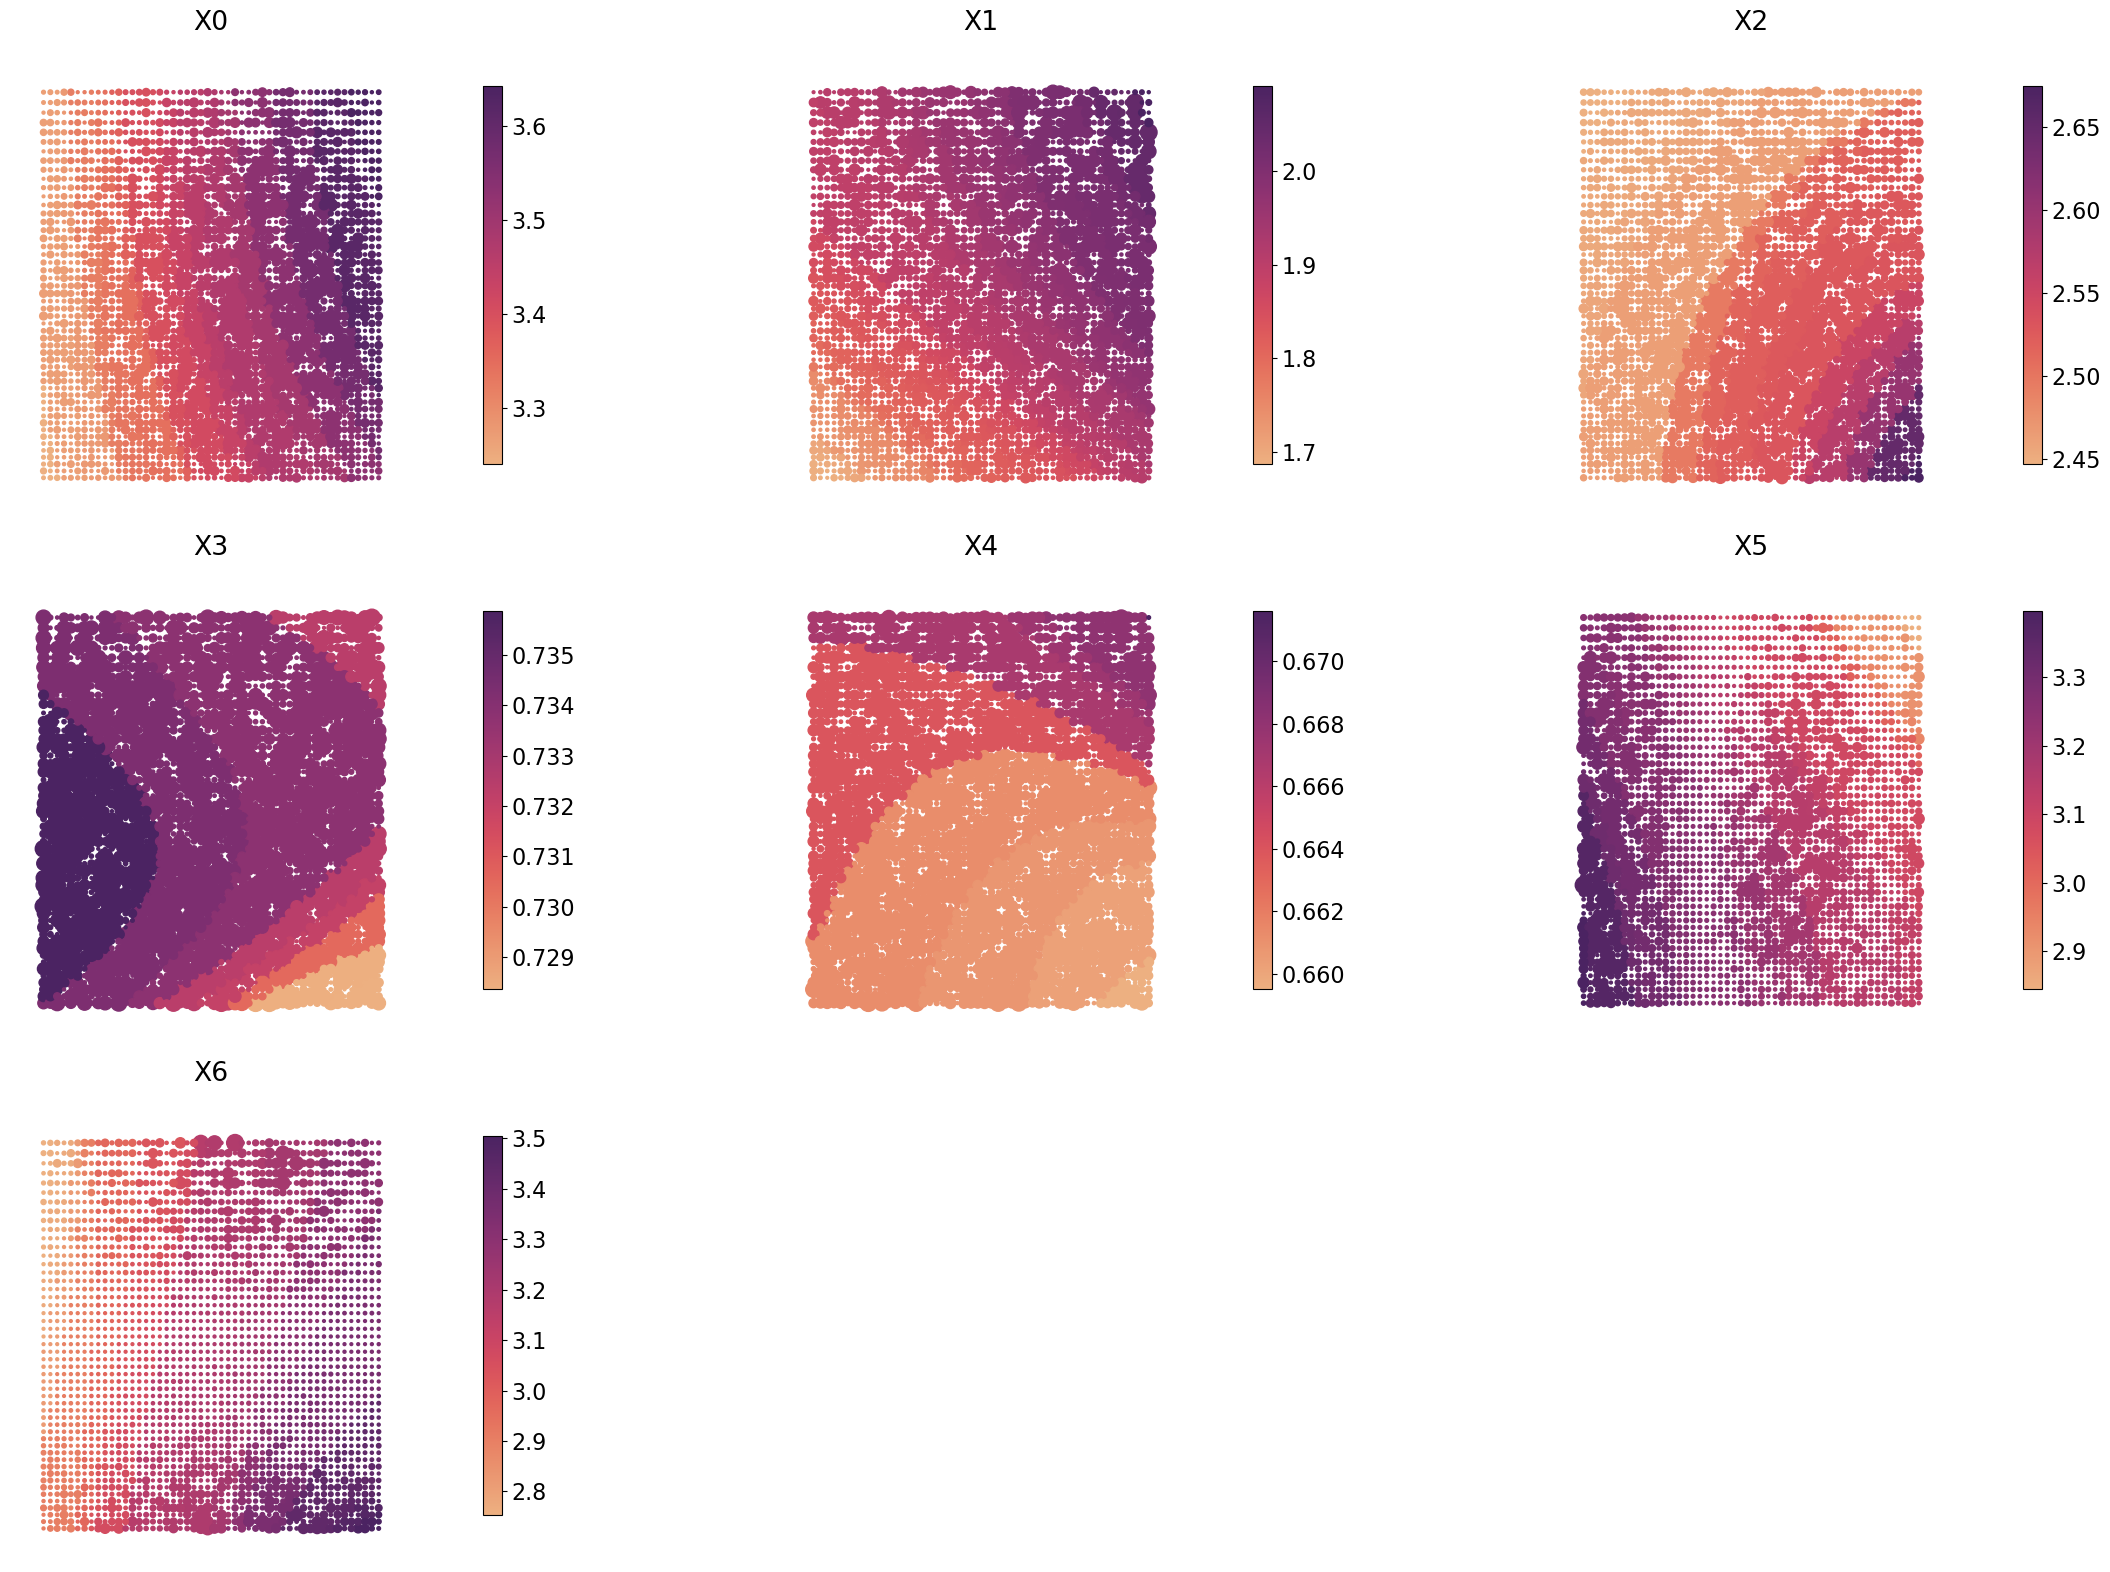

In [40]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [41]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [42]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

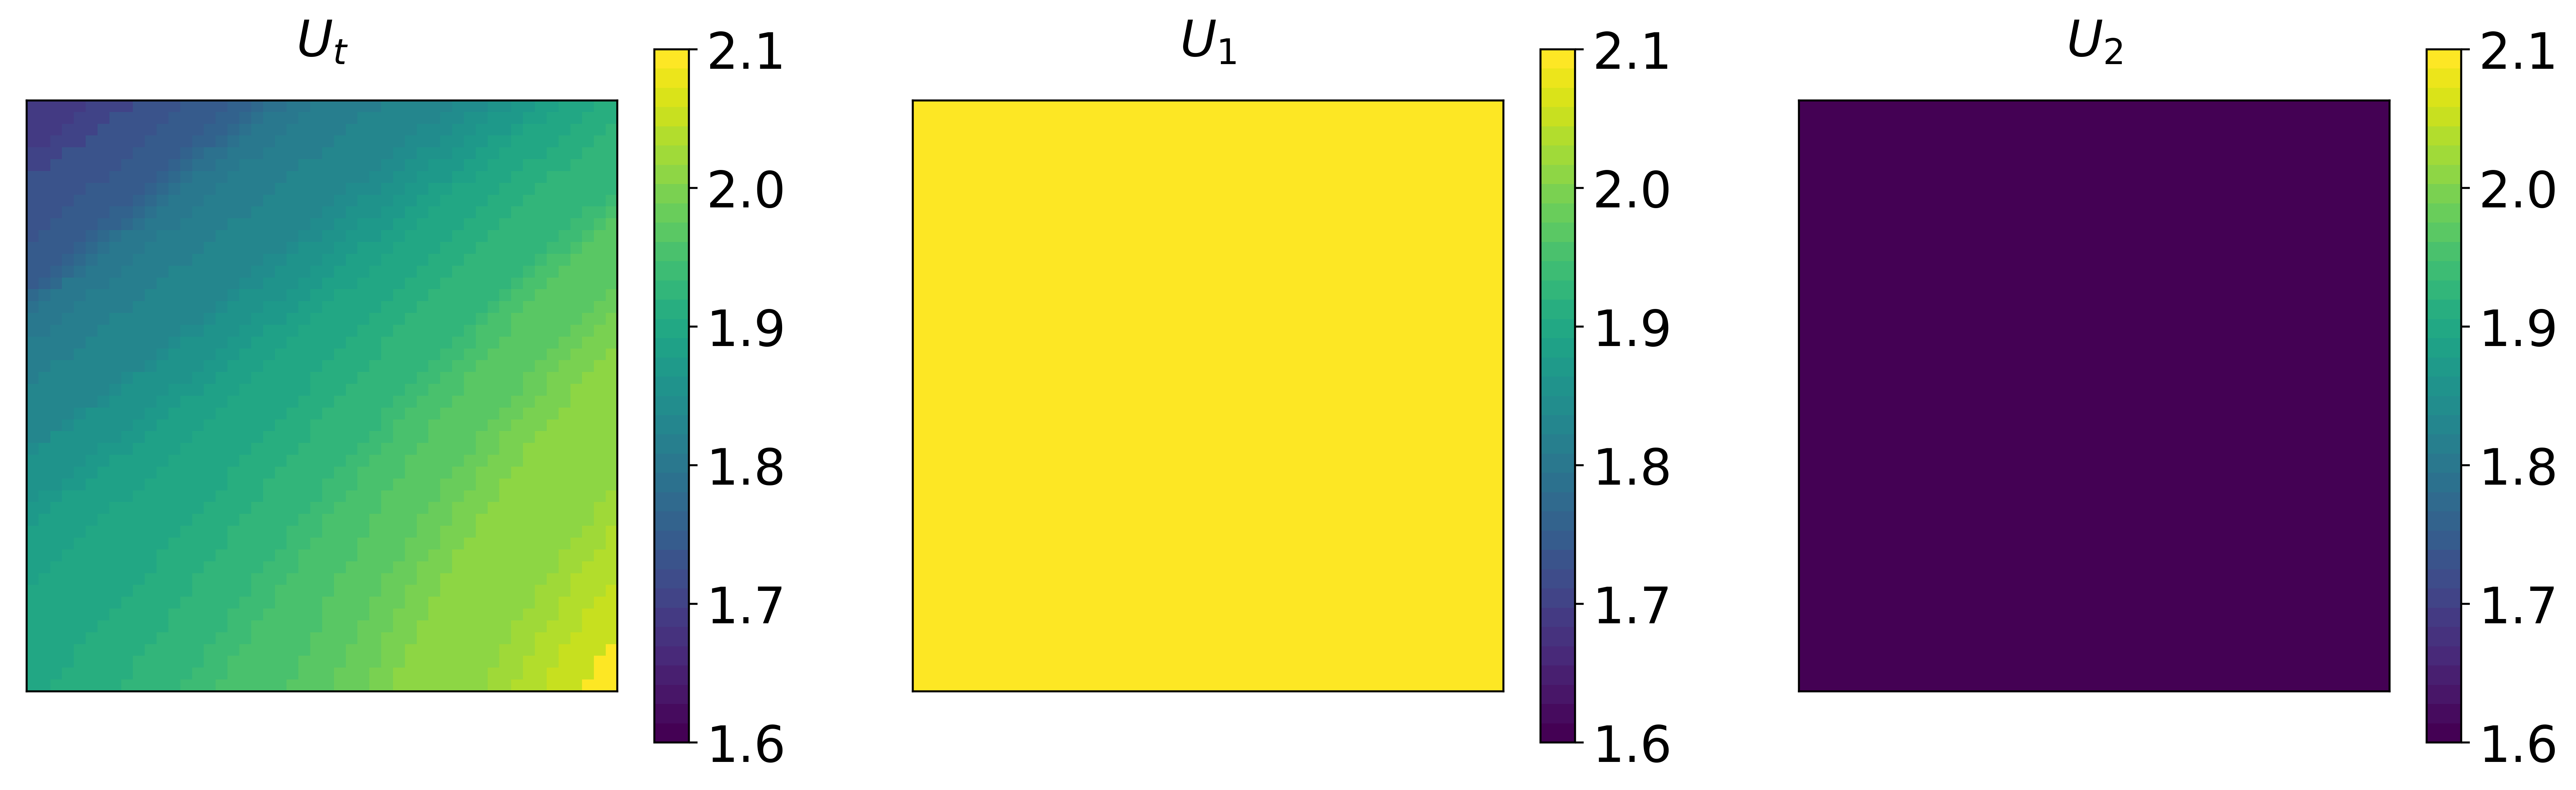

In [43]:
plot_contribution([pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=3, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

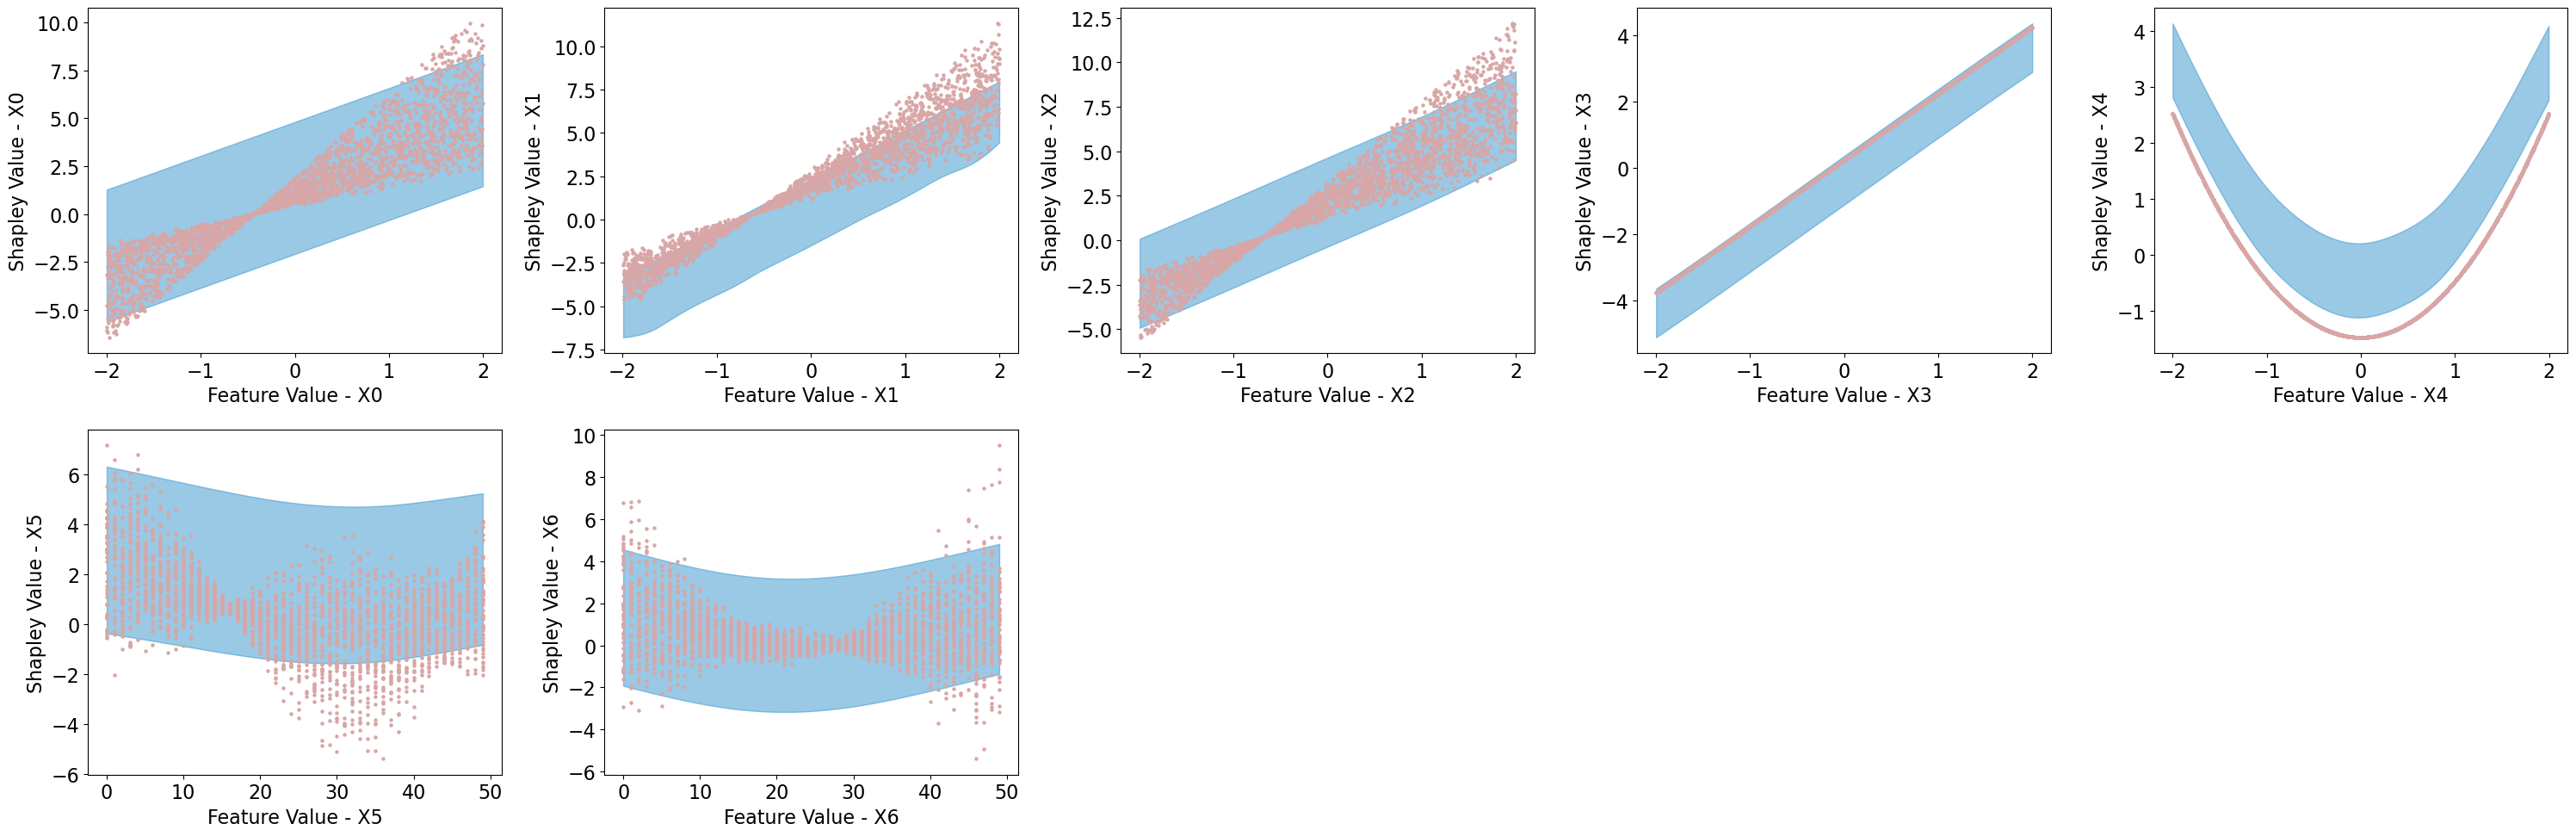

In [44]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)

In [45]:
explainer_without_uncertainty = GeoConformalizedExplainer(true_model_without_uncertainty, X_train, X_calib, loc_calib.values, loc.values, 0.1, 10)

NameError: name 'true_model_without_uncertainty' is not defined

In [42]:
results = explainer_without_uncertainty.uncertainty_aware_explain(x_test=X_coords, n_jobs=16)

Training SHAP


ExactExplainer explainer: 2001it [02:06, 14.45it/s]                          


Calibrating SHAP


ExactExplainer explainer: 501it [00:29, 11.56it/s]                         


Testing SHAP


ExactExplainer explainer: 2501it [02:26, 15.85it/s]                          


Explaining Variables


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [43]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     0.9624  0.985903  0.449793  14.351401      13.610568
X2                     0.9992  0.988538  0.396920  13.744562      13.457001
X3                     0.9644  0.972277  0.406454   5.959096       5.279495
X4                     0.9764  0.996650  0.135829   5.507205       5.427905
X5                     0.8864  0.938642  0.293964   1.408369       1.262291
x_coord                0.9372  0.687331  0.468936   0.703302       0.513662
y_coord                0.9236  0.904400  0.420490   1.849501       1.577228

In [44]:
pred_results = results.result

In [45]:
results.result_geo

X1_shap   X2_shap   X3_shap   X4_shap   X5_shap  x_coord_shap  \
0     0.402282  1.560145  0.784895  2.591669  1.150156     -1.182780   
1     1.471923 -0.742340 -0.820640  2.256475  1.283106      0.609109   
2     2.481585 -1.491541 -1.018764 -3.776410 -1.441611      0.962861   
3     1.260048  1.854833 -1.146176 -0.640815 -1.193696     -0.423604   
4    -2.881446  0.039190 -0.630565  2.332113 -1.469569      0.109652   
...        ...       ...       ...       ...       ...           ...   
2495 -7.560012 -3.413808 -0.025156 -2.519255  2.221087     -0.571663   
2496  1.974218 -2.923845  0.419647  0.905112 -1.475219     -0.670329   
2497 -7.193156 -4.640635 -0.665105  3.224179 -1.112315     -0.556437   
2498 -2.190753 -4.707821  0.636344  4.206248  1.237160     -1.088796   
2499  4.604215 -3.370276  0.454522  1.183082  0.144450     -0.855815   

      y_coord_shap  X1_value  X2_value  X3_value  ...  x_coord_pred  \
0        -1.176394  0.104114  0.964917  1.011381  ...     -1.041189   
1        -0.322766  0.741269 -0.440030 -0.936705  ...      1.062462   
2        -0.857672  1.342697 -0.875739 -1.148677  ...      1.253013   
3        -1.198843  0.615061  1.082512 -1.266801  ...     -0.136770   
4         3.581061 -1.851912  0.026923 -0.659943  ...      0.644841   
...            ...       ...       ...       ...  ...           ...   
2495     -3.391793 -1.798074 -0.779403  0.012337  ...     -0.443915   
2496     -0.841395  0.239688 -0.666447  0.497581  ...     -0.487646   
2497     -3.160428 -1.719665 -1.038000 -0.700350  ...     -0.422714   
2498     -2.354208 -0.650496 -1.045958  0.776005  ...     -0.879152   
2499     -0.151372  0.801800 -0.750421  0.581807  ...     -0.542183   

      y_coord_geo_uncertainty  y_coord_uncertainty  y_coord_upper_bound  \
0                    0.623429             0.752831            -1.131773   
1                    0.623429             0.752831            -0.012268   
2                    0.623429             0.752831            -0.395528   
3                    0.623429             0.752831            -0.752774   
4                    0.623429             0.752831             3.630794   
...                       ...                  ...                  ...   
2495                 0.893959             0.752831            -1.511413   
2496                 0.893959             0.752831             0.351123   
2497                 0.865967             0.752831            -1.587298   
2498                 0.865967             0.752831            -0.969940   
2499                 0.865967             0.752831             1.004687   

      y_coord_lower_bound  y_coord_coverage_probability  y_coord_pred     x  \
0               -2.378630                        0.9236     -1.755202   0.0   
1               -1.259126                        0.9236     -0.635697   1.0   
2               -1.642385                        0.9236     -1.018957   2.0   
3               -1.999631                        0.9236     -1.376203   3.0   
4                2.383936                        0.9236      3.007365   4.0   
...                   ...                           ...           ...   ...   
2495            -3.299331                        0.9236     -2.405372  45.0   
2496            -1.436796                        0.9236     -0.542837  46.0   
2497            -3.319231                        0.9236     -2.453264  47.0   
2498            -2.701874                        0.9236     -1.835907  48.0   
2499            -0.727247                        0.9236      0.138720  49.0   

         y                   geometry  
0      0.0    POINT (0.00000 0.00000)  
1      0.0    POINT (1.00000 0.00000)  
2      0.0    POINT (2.00000 0.00000)  
3      0.0    POINT (3.00000 0.00000)  
4      0.0    POINT (4.00000 0.00000)  
...    ...                        ...  
2495  49.0  POINT (45.00000 49.00000)  
2496  49.0  POINT (46.00000 49.00000)  
2497  49.0  POINT (47.00000 49.00000)  
2498  49.0  POINT (48.00000 49.00000)  

In [46]:
b = pred_results[['X1_pred', 'X2_pred', 'X3_pred', 'X4_pred', 'X5_pred']]

In [47]:
pred_b = [b['X1_pred'].values, b['X2_pred'].values, b['X3_pred'].values, [X_coords.values[:, 3], b['X4_pred'].values, -6, 6], [X_coords.values[:, 4], b['X5_pred'].values, -2, 5]]

In [48]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_{4}(X_4)$', r'$f_5(X_5)$']

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000015605BA4670> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

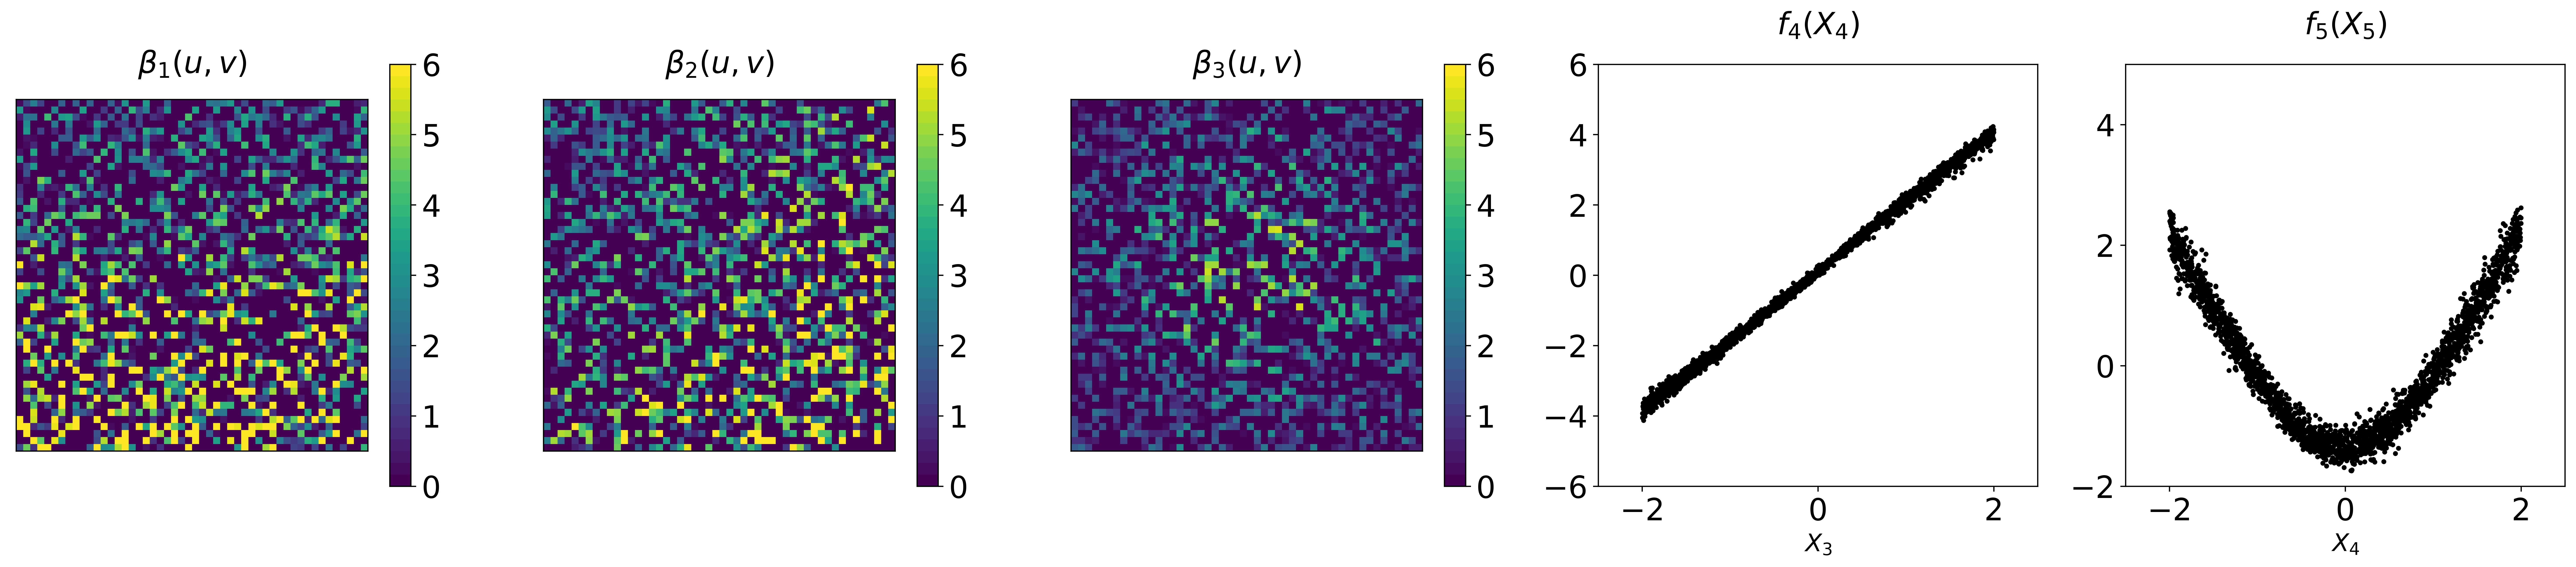

In [49]:
plot_contribution(pred_b, k=5, sub_titles=sub_titles, vmin=0, vmax=6, title='Synthetic data validation - ConformalSHAP', non_spatial=[3, 4])

In [50]:
plt.rcParams['font.size'] = 16

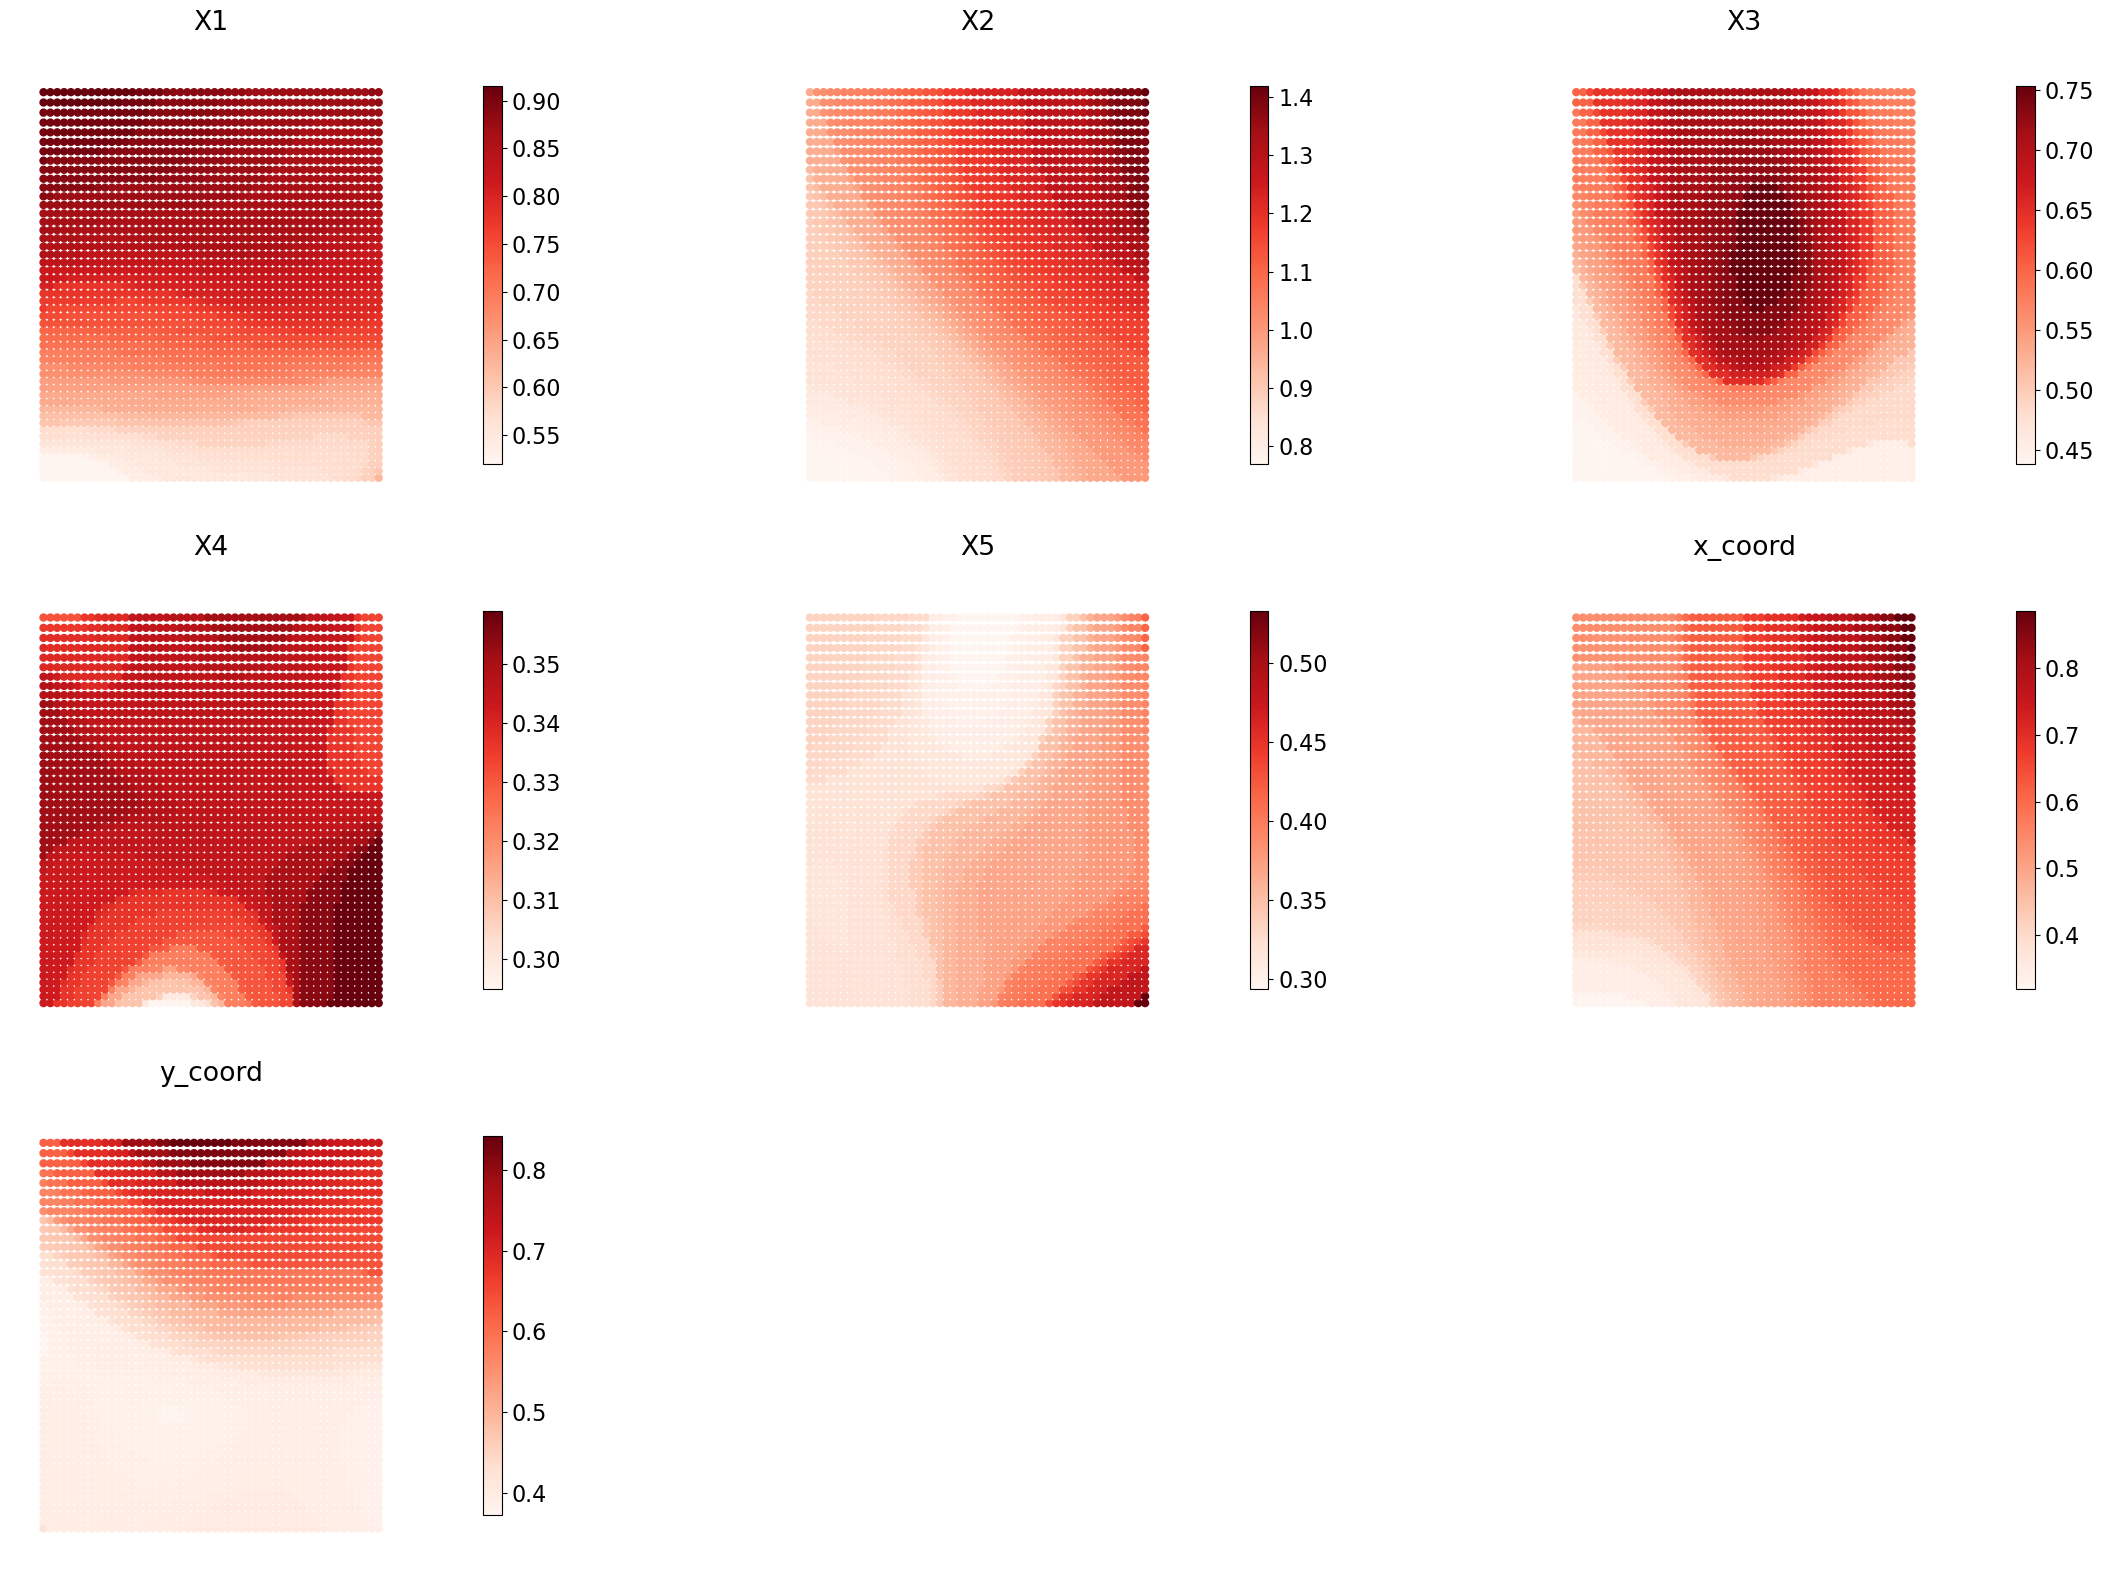

In [51]:
results.plot_geo_uncertainty(max_cols = 3, figsize=[30, 16], basemap=False)

In [52]:
geo_uncertainty_sum = pred_results['X1_geo_uncertainty'] + pred_results['X2_geo_uncertainty'] + pred_results['X3_geo_uncertainty'] + pred_results['X4_geo_uncertainty'] + pred_results['X5_geo_uncertainty']

In [53]:
sub_titles = [r'$U_t$', r'$U_1$', r'$U_2$', r'$U_3$', r'$U_4$', r'$U_5$']

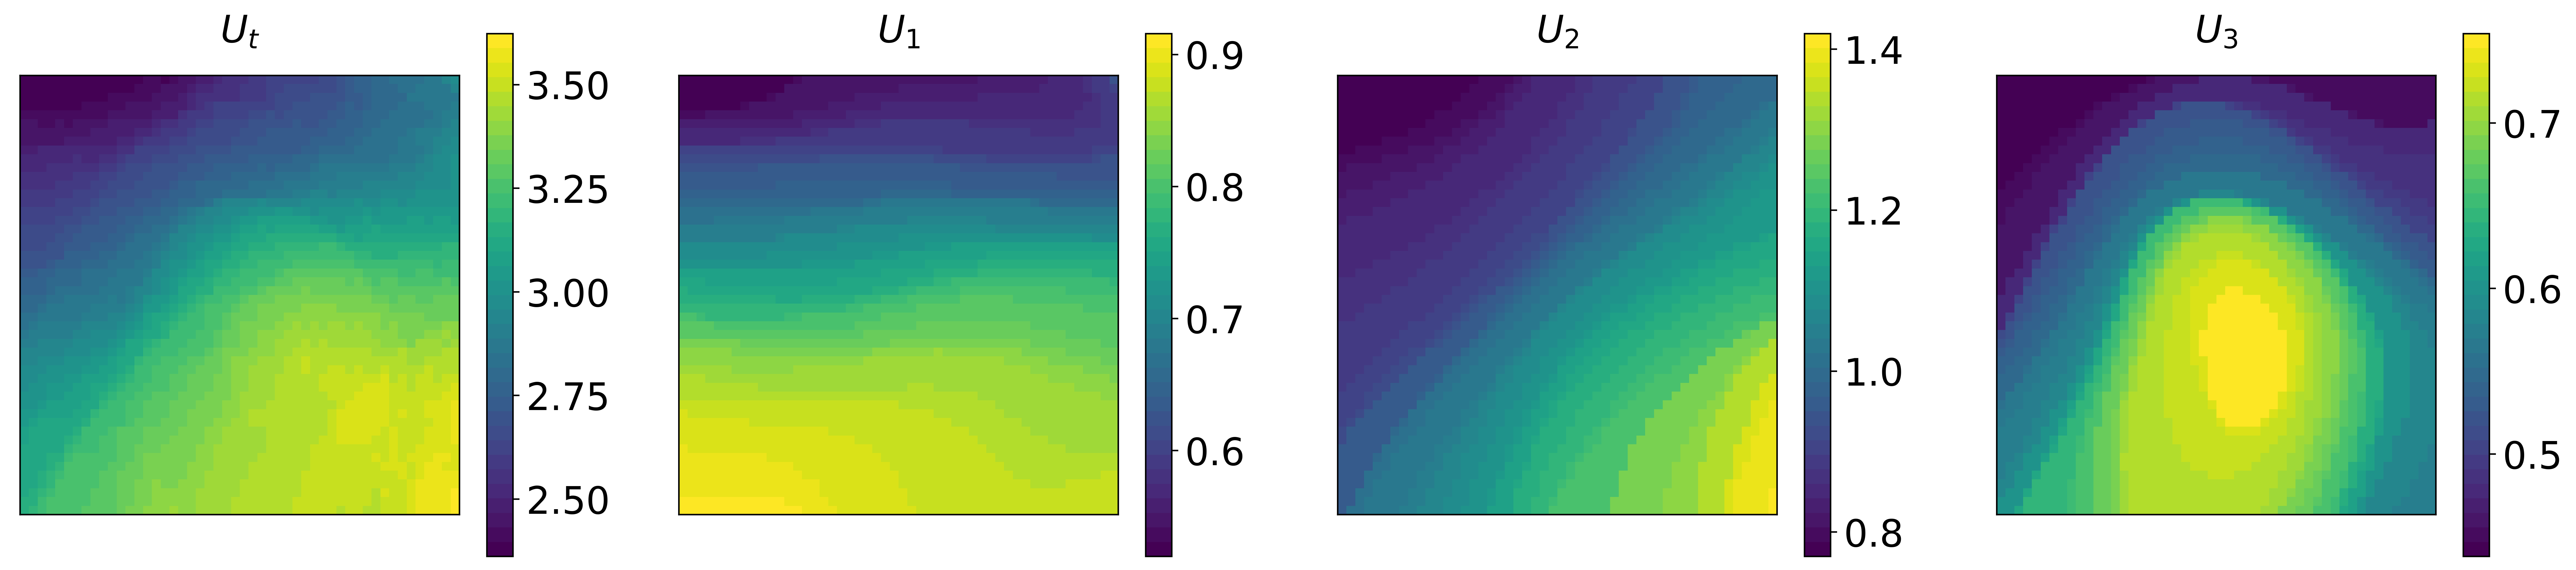

In [54]:
plot_contribution([geo_uncertainty_sum.values, pred_results['X1_geo_uncertainty'].values, pred_results['X2_geo_uncertainty'].values, pred_results['X3_geo_uncertainty'].values], k=4, title='Geo Uncertainty', sub_titles=sub_titles, non_spatial=[])

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

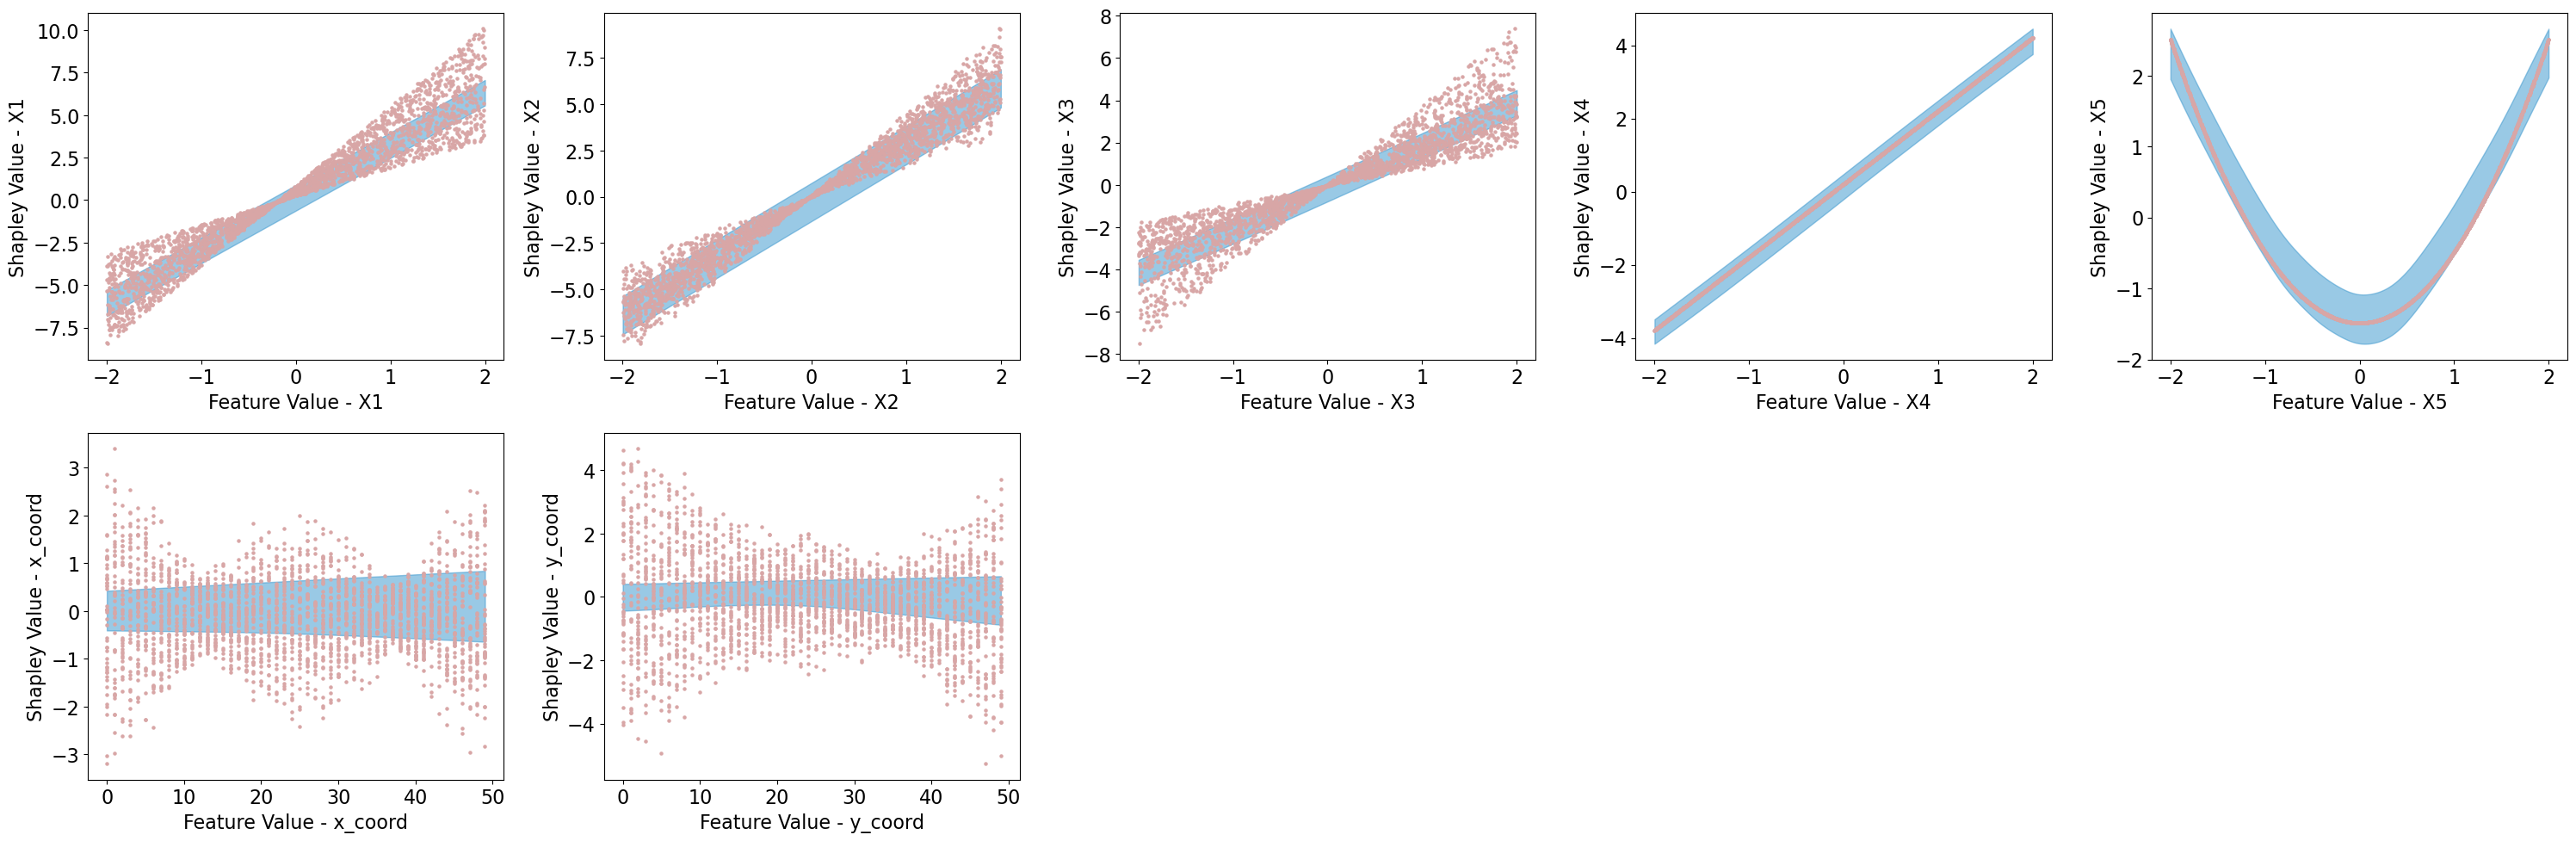

In [55]:
results.plot_partial_dependence_with_fitted_bounds(max_cols=5)